In [ ]:
import pandas as pd
import numpy as np
import os
import imp
import telephone_analysis
import srilm
import roark
import glob
import shutil
import scipy.stats
imp.reload(telephone_analysis)
import kenlm
import bllipparser
from bllipparser import RerankingParser
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import scipy.stats

import new_models
from new_models import gpt2_scores, bert_scores

%R library('plyr')
%R library('RColorBrewer')
%R library('colorRamps')
%R library('ggplot2')
%R library('plyr')
%R library('reshape2')
%R library('lme4')
%R library('lmerTest')
%R library('ggcorrplot')
%R library('ape')

# Combined analysis of Telephone Chains

In [ ]:
import load_runs
all_runs = load_runs.load_runs() # The same code as in the original Aggregate iPynb code.

# Language Models

In [ ]:
bnc_knn_lm = srilm.LM("LMs/BNC_merged.LM", lower=True)

In [ ]:
# each column added by a language model needs to be of the format <model>_<measure>

In [ ]:
# n-gram models
all_runs['BNC_KNN_trigramProb'] = [telephone_analysis.getLogProb(x, {}, bnc_knn_lm) for x in all_runs['user_candidate_transcription']]
all_runs['BNC_KNN_unigramProb'] = [telephone_analysis.getLogProb(x, {}, bnc_knn_lm, unigram=True) for x in all_runs['user_candidate_transcription']]

In [ ]:
all_runs['BNC_KNN_trigramProb']

In [ ]:
wsj_gt_unigram_lm = srilm.LM("LMs/wsj_unigram.LM", lower=True) 
all_runs['WSJ_gt_unigramProb'] = [telephone_analysis.getLogProb(x, {}, wsj_gt_unigram_lm, unigram=True) for x in all_runs['user_candidate_transcription']]

In [ ]:
wsj_gt_trigram_lm = srilm.LM("LMs/wsj_trigram.LM", lower=True) 
all_runs['WSJ_gt_trigramProb'] = [telephone_analysis.getLogProb(x, {}, wsj_gt_trigram_lm, unigram=False) for x in all_runs['user_candidate_transcription']]

In [ ]:
wsj_gt_5gram_lm = srilm.LM("LMs/wsj_5gram.LM", lower=True) 
all_runs['WSJ_gt_5gramProb'] = [telephone_analysis.getLogProb(x, {}, wsj_gt_5gram_lm, unigram=False) for x in all_runs['user_candidate_transcription']]

In [ ]:
# roark model
roarkSentenceProbs = roark.parse([str(i) for i in all_runs['user_candidate_transcription']], 
    '/home/nwong/utils/incremental-top-down-parser',
                          numWorkers=24, mode='sentence')
all_runs['WSJ_Roark_Negative.Log.Probability'] = [roarkSentenceProbs[x].iloc[0]['prefix.1'] for x in all_runs['user_candidate_transcription']]

In [ ]:
big_lm_scores = telephone_analysis.getBigLMscores(all_runs['user_candidate_transcription'], 'big_lm',
    'big_lm_cache', colname='BigLM_probability', lm_1b_dir='/home/stephan/python/lm_1b')
all_runs['biglm_probability'] =  big_lm_scores

In [ ]:
# KenLM
m = kenlm.Model('LMs/deepspeech_5gram.binary')
all_runs['kenlm_probability'] = [telephone_analysis.getKenLMProb(x, m) for x in all_runs['user_candidate_transcription']]

In [ ]:
#Johnson-Charniak parser: WSJ + Google Treebank
if 'rrp' in locals() or 'rrp' in globals():
    RerankingParser._parser_model_loaded = False
rrp = RerankingParser.from_unified_model_dir('LMs/SANCL2012-Uniform')
all_runs['bllip_probability'] = [telephone_analysis.getCharniakJohnsonBeamProb(x, rrp) for x in all_runs['user_candidate_transcription']]

In [ ]:
#Johnson-Charniak parser: WSJ only
if 'rrp' in locals() or 'rrp' in globals():
    RerankingParser._parser_model_loaded = False
rrp = RerankingParser.from_unified_model_dir('LMs/WSJ-PTB3')
all_runs['bllip_wsj_probability'] = [telephone_analysis.getCharniakJohnsonBeamProb(x, rrp) for x in all_runs['user_candidate_transcription']]

In [ ]:
# Mikolov RNN
all_runs['mikolov_wsj_probability'] = telephone_analysis.getMikolovWSJprobs(all_runs['user_candidate_transcription'], '/shared_hd1/datasets/Mikolov_Treebank/simple-examples/', os.getcwd())

### Transformer-based models: Uses precomputed results

To re-score sentences with the transformers, please see the new_model_run.py

In [ ]:
RESULTS_FOLDER = './intermediate_results/new_models_probs'

from new_models import prep_probs
import importlib
importlib.reload(prep_probs)

# For consistency, it's named probability, but these are actually negative base-10 surprisals.
for model_name in ['gpt2_normal', 'gpt2_medium', 'bert', 'bart']:
    all_runs[f'{model_name}_probability'] = prep_probs.load_sentence_scores(model_name, RESULTS_FOLDER)

In [ ]:
language_model_measures = ['biglm_probability', u'WSJ_Roark_Negative.Log.Probability', 
          u'BNC_KNN_unigramProb', u'BNC_KNN_trigramProb','kenlm_probability','bllip_probability',
        'bllip_wsj_probability', 'mikolov_wsj_probability','WSJ_gt_unigramProb'
        ,'WSJ_gt_trigramProb', 'WSJ_gt_5gramProb','gpt2_normal_probability', 'gpt2_medium_probability',
                           'bert_probability', 'bart_probability'
]

In [ ]:
import os

if not os.path.exists('./intermediate_results'):
    os.makedirs('./intermediate_results')

In [ ]:
all_runs.to_csv('./intermediate_results/all_runs_raw_model_outputs.csv')
# This is the save before running Cell 63.
# To prevent repetitive re-normalizing.

In [ ]:
all_runs

## Load raw caches of all_runs data.

In [112]:
## RUN VISUALIZATIONS FROM SAVED VALUES HERE

## 3/20: The intermediate results were run starting from this line.

all_runs = pd.read_csv('./intermediate_results/all_runs_raw_model_outputs.csv')

In [113]:
language_model_measures = ['biglm_probability', u'WSJ_Roark_Negative.Log.Probability', 
          u'BNC_KNN_unigramProb', u'BNC_KNN_trigramProb','kenlm_probability','bllip_probability',
        'bllip_wsj_probability', 'mikolov_wsj_probability','WSJ_gt_unigramProb'
        ,'WSJ_gt_trigramProb', 'WSJ_gt_5gramProb',
        'gpt2_normal_probability', 'gpt2_medium_probability', 'bert_probability', 'bart_probability'
]

In [114]:
# normalize all language model measures by the number of words
all_runs['length_in_words'] = [telephone_analysis.getLengthInWords(x, {}) for x in all_runs['user_candidate_transcription']]
for x in language_model_measures:
    all_runs['normalized_'+x] = all_runs[x] / all_runs['length_in_words']

In [116]:
all_runs.iloc[0]

Unnamed: 0                                                                                       0
chain                                                                                            0
character_levdau                                                                               NaN
check_time                                                                                     NaN
condition                                                                                      NaN
flag_type                                                                                      NaN
gold_candidate_transcription                                                                   NaN
gold_comparison_transcription                                                                  NaN
gold_dist                                                                                      NaN
length_accept                                                                                  NaN
reason    

In [117]:
# delete all columns starting with initial
cols_to_drop = np.array(all_runs.columns.tolist())[np.argwhere(['initial_' in x for x in  all_runs.columns])].flatten()
all_runs = all_runs.drop(labels = cols_to_drop, axis = 'columns')

# mege them in and recompute initial per-word probabilities
for language_model_measure in language_model_measures:    
    initialProbs = telephone_analysis.getInitialProbs(all_runs, language_model_measure) 
    
    if 'initial_'+language_model_measure not in all_runs.columns:
        all_runs = all_runs.merge(initialProbs, on='stimulus_id', how='outer')

Getting initial probabilities for biglm_probability
Getting initial probabilities for WSJ_Roark_Negative.Log.Probability
Getting initial probabilities for BNC_KNN_unigramProb
Getting initial probabilities for BNC_KNN_trigramProb
Getting initial probabilities for kenlm_probability
Getting initial probabilities for bllip_probability
Getting initial probabilities for bllip_wsj_probability
Getting initial probabilities for mikolov_wsj_probability
Getting initial probabilities for WSJ_gt_unigramProb
Getting initial probabilities for WSJ_gt_trigramProb
Getting initial probabilities for WSJ_gt_5gramProb
Getting initial probabilities for gpt2_normal_probability
Getting initial probabilities for gpt2_medium_probability
Getting initial probabilities for bert_probability
Getting initial probabilities for bart_probability


In [118]:
all_runs

,Unnamed: 0,chain,character_levdau,check_time,condition,flag_type,gold_candidate_transcription,gold_comparison_transcription,gold_dist,length_accept,...,initial_gpt2_normal_probability_quartile,initial_gpt2_medium_probability,initial_gpt2_medium_probability_rank,initial_gpt2_medium_probability_quartile,initial_bert_probability,initial_bert_probability_rank,initial_bert_probability_quartile,initial_bart_probability,initial_bart_probability_rank,initial_bart_probability_quartile
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
1,1,0,0.038462,820.0,cafe,NaN,each nonfiction book has a call number on its ...,each non viction book has a called number on i...,0.074074,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
2,2,0,0.076923,767.0,cafe,NaN,each non fiction book has a call number in its...,each nonfiction book had a can number on its s...,0.096154,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
3,3,0,0.019608,937.0,cafe,NaN,Each nonfiction book had a call number on its ...,each nonfictionblekaracall number on its fine,0.215686,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
4,4,0,0.019231,964.0,cafe,NaN,each nonfiction book had a call number on its ...,each nonfiction book had a call number on its ...,0.000000,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
5,5,0,0.019231,967.0,cafe,NaN,each non fiction book had a call number on its...,each nonfiction book had a call number on its ...,0.057692,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
6,6,0,0.176471,527.0,cafe,NaN,each nonfiction book had a call number on its ...,each nonficin book had twelve numbers on its s...,0.176471,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
7,7,0,0.134615,591.0,cafe,NaN,Each non fiction book had 12 numbers on its spine,ach none fiction both had twelve numbers on it...,0.254902,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
8,8,0,0.037736,844.0,cafe,NaN,Each nonfiction book had twelve numbers on its...,each nonfiction book had twelve numbers on its...,0.019231,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0
9,9,0,0.113208,1045.0,cafe,NaN,each non fiction book had twelve numbers on it...,each nonfiction book had twelve notches on its...,0.132075,NaN,...,0.0,-23.961809,12,1.0,-13.294642,0,0.0,-16.233868,13,1.0


In [120]:
# # R cannot handle nans, so need to replace with nones
for x in ['condition','flag_type','gold_candidate_transcription',
          'gold_comparison_transcription','reason', 'subject_id',
         'upstream_subject_id', 'user_comparison_transcription', 'user_short']:
    all_runs[x] = all_runs[x].fillna(value="none")

%R -i all_runs

/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "gold_candidate_transcription". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/tel

In [121]:
all_runs['thread_id'] = all_runs['global_chain'].map(str) + '_' + [str(x) for x in all_runs['stimulus_id']]

In [122]:
RESULTS_FOLDER = './intermediate_postprocessed_results'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER) # You can't join the file simply because it will re-normalize the data every time you do so.
    
SAVE_RESULTS_PATH = os.path.join(RESULTS_FOLDER, 'all_runs_postprocessed.csv')
all_runs.to_csv(SAVE_RESULTS_PATH)

# Chain Analysis

In [123]:
# number of threads (initial sentence * chain) per chain
numThreadsPerChain = all_runs.groupby(['global_chain','upstream_pointer']).stimulus.agg(lambda x: len(np.unique(x))).reset_index()
numThreadsPerChain.sort_values(by='upstream_pointer')
print(numThreadsPerChain.columns)
%R -i numThreadsPerChain

Index(['global_chain', 'upstream_pointer', 'stimulus'], dtype='object')


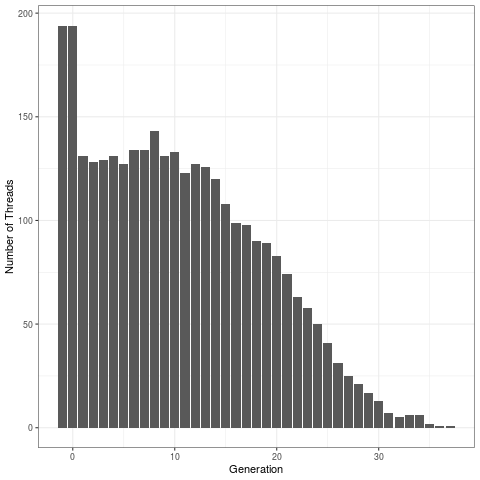

In [124]:
%%R
ggplot(numThreadsPerChain) + geom_bar(aes(x=upstream_pointer, y=stimulus), stat='identity'
) + theme_bw() + xlab('Generation') + ylab('Number of Threads')

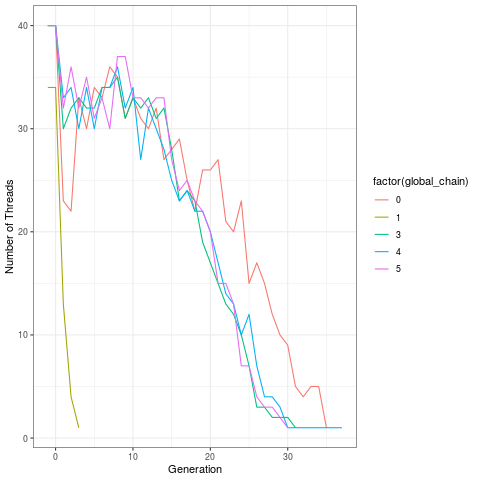

In [125]:
%%R
ggplot(numThreadsPerChain) + geom_line(aes(x=upstream_pointer, y=stimulus, colour=factor(global_chain)), stat='identity'
) + theme_bw() + xlab('Generation') + ylab('Number of Threads')

In [126]:
recordingChainLengths = all_runs.groupby(['thread_id','stimulus_id','global_chain']).upstream_pointer.agg(np.max).reset_index().sort_values('upstream_pointer')
recordingChainLengths.columns = ['thread_id','stimulus_id','global_chain','chain_length'] 
print(recordingChainLengths)

    thread_id  stimulus_id  global_chain  chain_length
67       1_37           37             1             0
46       1_16           16             1             0
47       1_17           17             1             0
48       1_18           18             1             0
49       1_19           19             1             0
50        1_2            2             1             0
51       1_20           20             1             0
52       1_21           21             1             0
54       1_24           24             1             0
55       1_25           25             1             0
57       1_27           27             1             0
41        1_1            1             1             0
60        1_3            3             1             0
61       1_30           30             1             0
59       1_29           29             1             0
40        1_0            0             1             0
64       1_33           33             1             0
66       1

In [127]:
initialSentences =  all_runs.loc[(all_runs.upstream_pointer == -1) & (all_runs.global_chain == 0)]
initialSentences = initialSentences.drop(['upstream_pointer','global_chain','thread_id'], axis=1)

In [128]:
recordingChainLengths_aug = recordingChainLengths.merge(initialSentences, left_on='stimulus_id', right_on='stimulus_id')
recordingChainLengths_short = recordingChainLengths_aug[['stimulus_id','thread_id','global_chain','initial_BNC_KNN_unigramProb','chain_length']]
%R -i recordingChainLengths_short

/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "thread_id". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


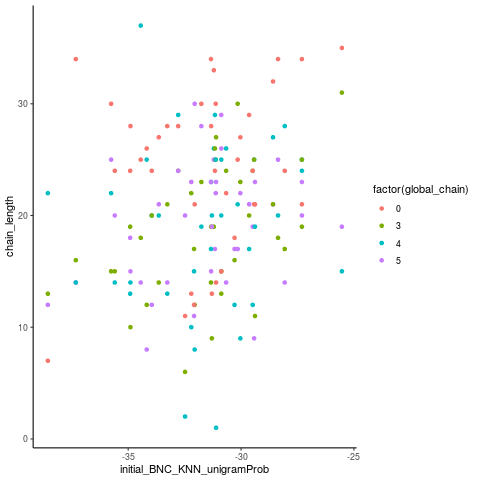

In [129]:
%%R
ggplot(subset(recordingChainLengths_short, global_chain != 1)) + geom_point(aes(x=initial_BNC_KNN_unigramProb, y=chain_length,
colour= factor(global_chain))) + theme_classic()

In [130]:
%%R
summary(lm(chain_length ~ initial_BNC_KNN_unigramProb, subset(recordingChainLengths_short, global_chain != 1)))


Call:
lm(formula = chain_length ~ initial_BNC_KNN_unigramProb, data = subset(recordingChainLengths_short, 
    global_chain != 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-19.5759  -4.6605   0.0381   4.6052  18.2529 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  37.6299     6.1777   6.091 8.21e-09 ***
initial_BNC_KNN_unigramProb   0.5482     0.1947   2.816  0.00549 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.739 on 158 degrees of freedom
Multiple R-squared:  0.04778,	Adjusted R-squared:  0.04175 
F-statistic: 7.928 on 1 and 158 DF,  p-value: 0.005487



In [131]:
if 'chain_length' not in all_runs.columns:
    all_runs = all_runs.merge(recordingChainLengths_short[['thread_id','chain_length']])

In [132]:
all_runs.to_csv('output/all_runs.csv')

In [133]:
all_runs = pd.read_csv('output/all_runs.csv')

# How do Chains Behave?

In [134]:
# Functions with R code. Cannot be added to the telephone_analysis helper
def SEMbyFactor(df, factorVar, measureVar, graphTitle, maxGeneration=0):
    # standard error of the mean, stratified by initial conditions
    by_factor = df.groupby([factorVar, 'upstream_pointer'])[measureVar].agg([np.mean, np.std, scipy.stats.sem]).reset_index()
    print(by_factor.columns)
    
    by_factor['min'] = by_factor['mean'] - by_factor['sem']
    by_factor['max'] = by_factor['mean'] + by_factor['sem']
    
    %R print('colorizing by:')
    %R print(paste0(gsub('normalized_', 'initial_',measureVar),'_quartile'))
    %R -i by_factor,measureVar,graphTitle,factorVar,maxGeneration,df
    %R if (maxGeneration > 0){by_factor = subset(by_factor, upstream_pointer <= maxGeneration)}
    %R by_factor[[factorVar]] = factor(by_factor[[factorVar]])
    %R print(ggplot(by_factor) + geom_line(aes_string(y='mean', x='upstream_pointer', \
    colour=factorVar)) + theme_bw() + ggtitle(graphTitle) + xlab('Generation') \
    + geom_errorbar(aes_string(x='upstream_pointer', ymin='min', ymax='max', colour=factorVar)) \
    + ylab('Log Probability') + theme(legend.position="none"))
    

Index(['global_chain', 'upstream_pointer', 'mean', 'std', 'sem'], dtype='object')
[1] "colorizing by:"
[1] "initial_biglm_probability_quartile"


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: m

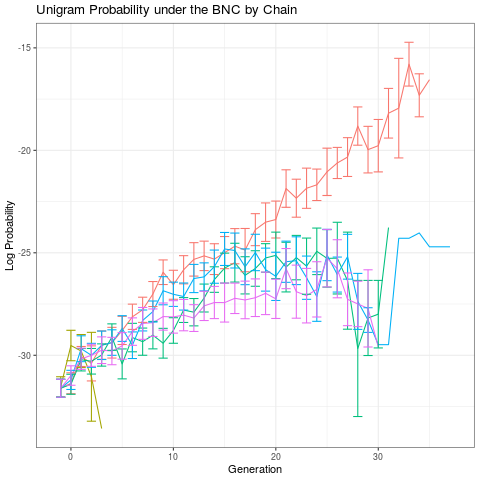

In [135]:
SEMbyFactor(all_runs, 'global_chain', 'BNC_KNN_unigramProb', 'Unigram Probability under the BNC by Chain')

Index(['global_chain', 'upstream_pointer', 'mean', 'std', 'sem'], dtype='object')
[1] "colorizing by:"
[1] "BNC_KNN_unigramProb_quartile"


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: m

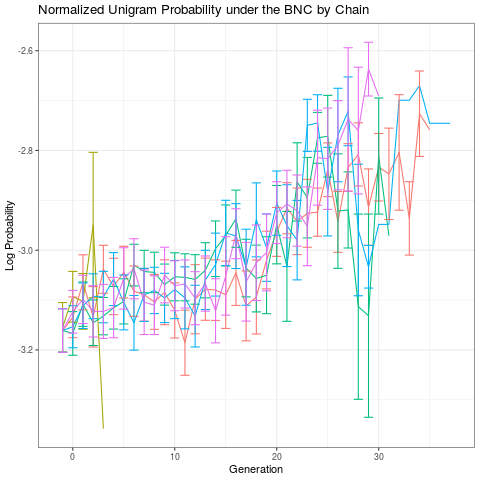

In [136]:
SEMbyFactor(all_runs, 'global_chain', 'normalized_BNC_KNN_unigramProb', 'Normalized Unigram Probability under the BNC by Chain')

Index(['global_chain', 'upstream_pointer', 'mean', 'std', 'sem'], dtype='object')
[1] "colorizing by:"
[1] "initial_BNC_KNN_unigramProb_quartile"


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: m

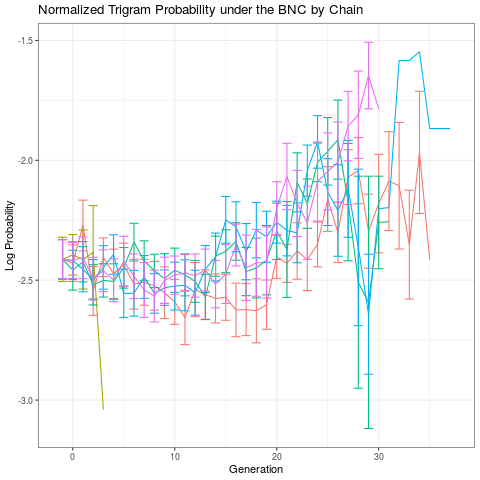

In [137]:
SEMbyFactor(all_runs, 'global_chain', 'normalized_BNC_KNN_trigramProb', 'Normalized Trigram Probability under the BNC by Chain')

# How do Threads Behave?

/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Index(['thread_id', 'upstream_pointer', 'mean', 'std', 'sem'], dtype='object')
[1] "colorizing by:"
[1] "initial_BNC_KNN_trigramProb_quartile"


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "thread_id". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/py

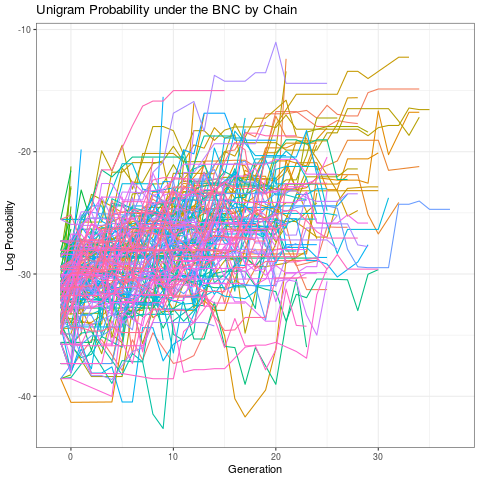

In [138]:
SEMbyFactor(all_runs, 'thread_id', 'BNC_KNN_unigramProb', 'Unigram Probability under the BNC by Chain')

# Behavior By Initial Probability

Index(['initial_bart_probability_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "BNC_KNN_unigramProb_quartile"


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "flag_type". Fall back to string conversion. The error is: m

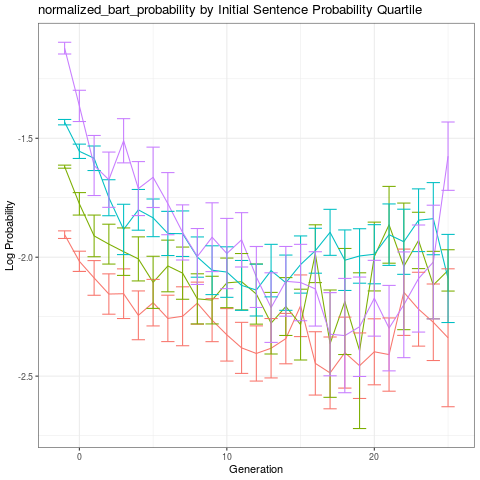

Index(['initial_bert_probability_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_bart_probability_quartile"


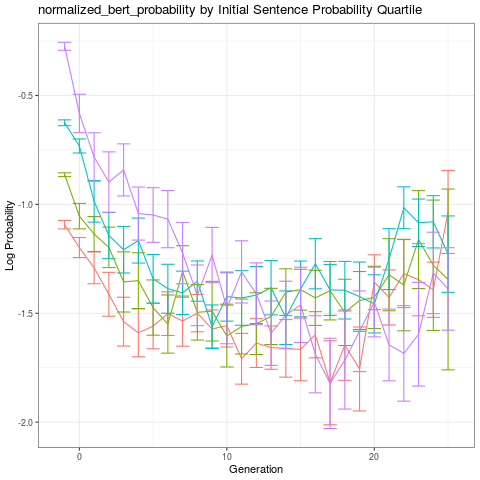

Index(['initial_gpt2_medium_probability_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_bert_probability_quartile"


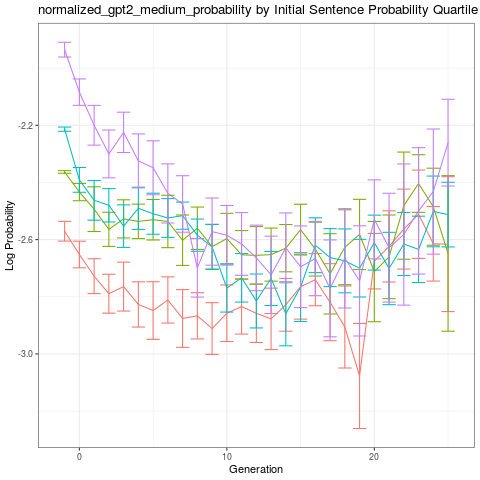

Index(['initial_gpt2_normal_probability_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_gpt2_medium_probability_quartile"


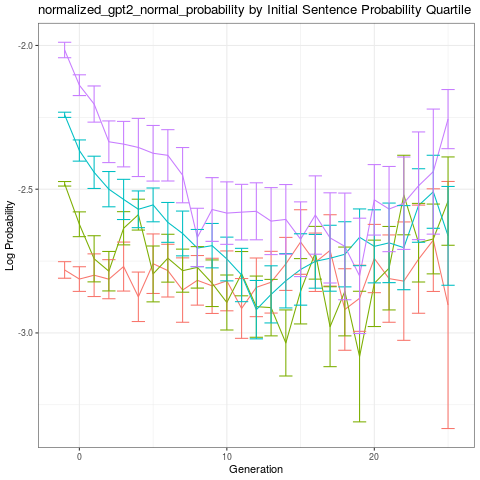

Index(['initial_WSJ_gt_5gramProb_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_gpt2_normal_probability_quartile"


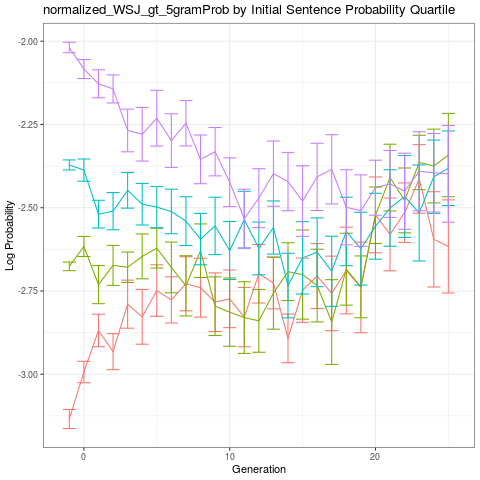

Index(['initial_WSJ_gt_trigramProb_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_WSJ_gt_5gramProb_quartile"


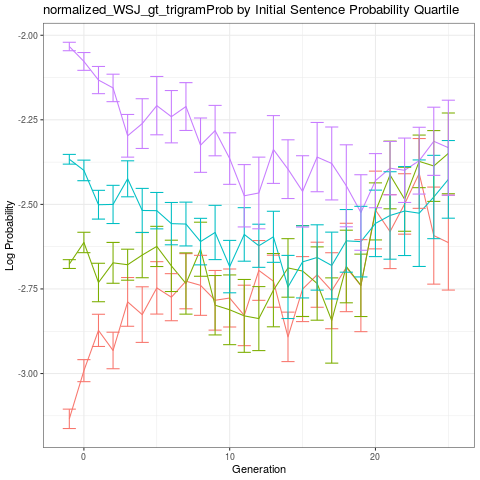

Index(['initial_WSJ_gt_unigramProb_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_WSJ_gt_trigramProb_quartile"


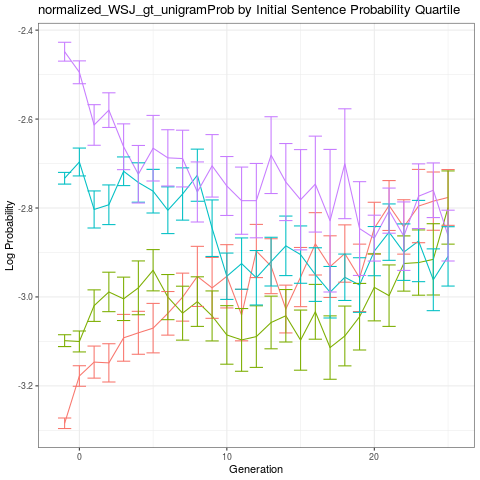

Index(['initial_mikolov_wsj_probability_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_WSJ_gt_unigramProb_quartile"


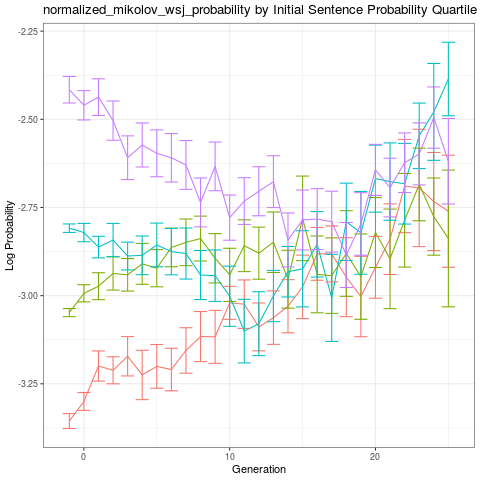

Index(['initial_bllip_wsj_probability_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_mikolov_wsj_probability_quartile"


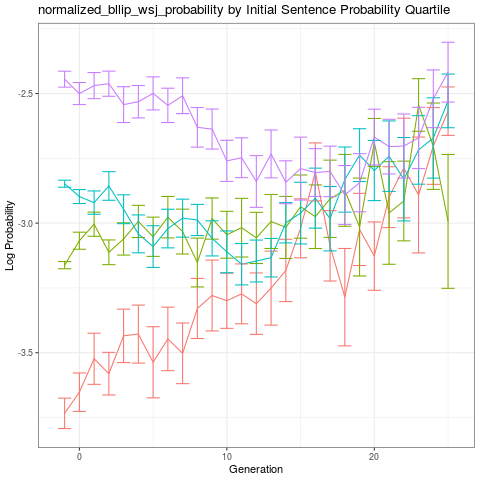

Index(['initial_bllip_probability_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_bllip_wsj_probability_quartile"


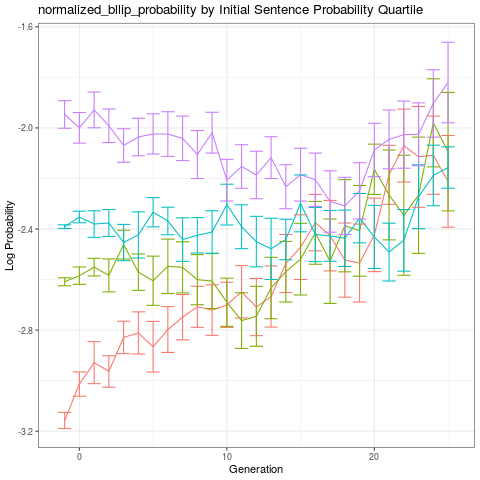

Index(['initial_kenlm_probability_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_bllip_probability_quartile"


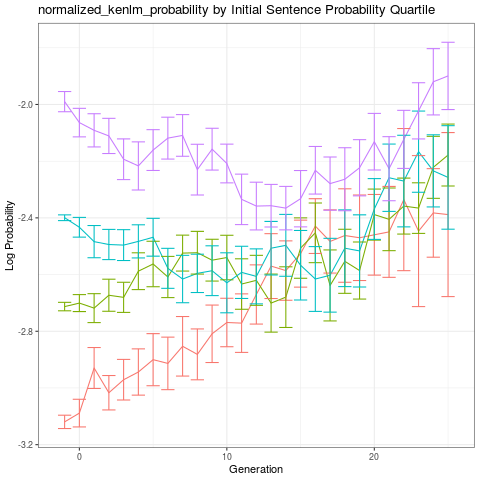

Index(['initial_BNC_KNN_trigramProb_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_kenlm_probability_quartile"


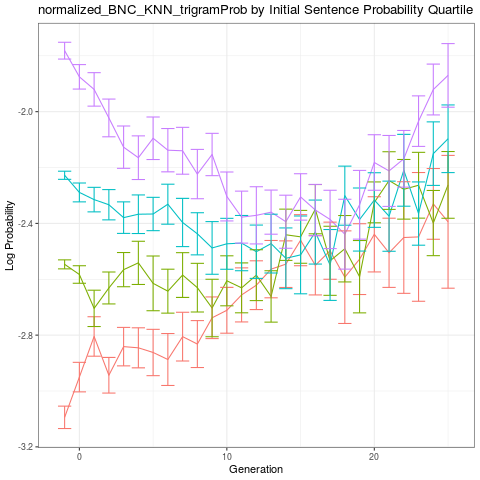

Index(['initial_BNC_KNN_unigramProb_quartile', 'upstream_pointer', 'mean',
       'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_BNC_KNN_trigramProb_quartile"


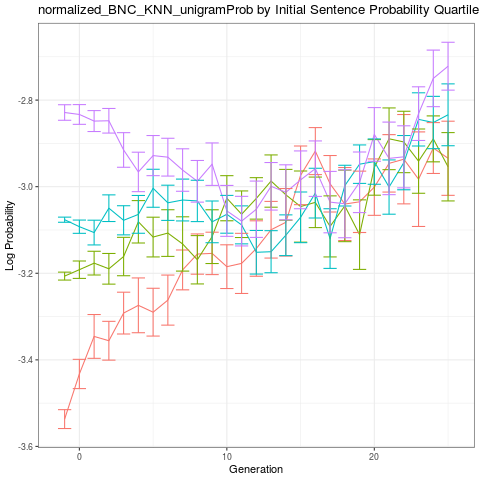

Index(['initial_WSJ_Roark_Negative.Log.Probability_quartile',
       'upstream_pointer', 'mean', 'std', 'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_BNC_KNN_unigramProb_quartile"


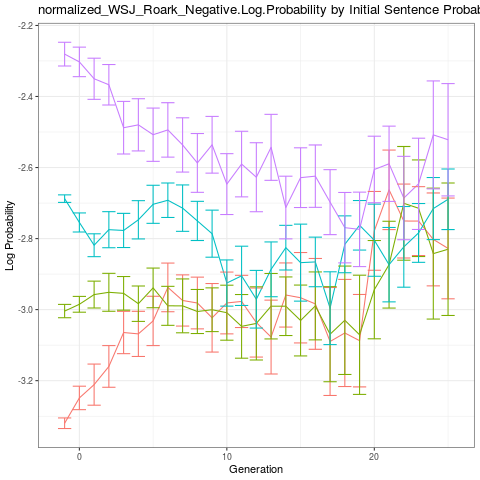

Index(['initial_biglm_probability_quartile', 'upstream_pointer', 'mean', 'std',
       'sem'],
      dtype='object')
[1] "colorizing by:"
[1] "initial_WSJ_Roark_Negative.Log.Probability_quartile"


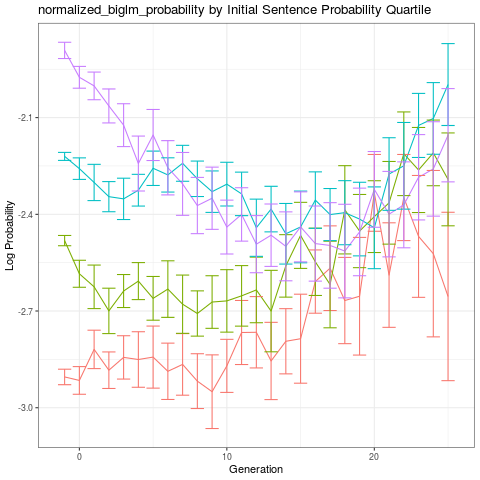

In [139]:
for language_model_measure in language_model_measures[::-1]:
    SEMbyFactor(all_runs, 'initial_'+language_model_measure+'_quartile', 'normalized_'+language_model_measure, 'normalized_'+language_model_measure+' by Initial Sentence Probability Quartile', maxGeneration=25)

# Variance Reduction By Model

In [142]:
normalizedVars = ['normalized_'+ x for x in language_model_measures]

In [143]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

In [144]:
%%R
single_df$model = factor(single_df$model)

This claims that single_df is not defined.

In [145]:
%%R
levels(single_df$model)

 [1] "BC+EW / BERT"                  "BNC / Kneser-Ney Trigram"     
 [3] "BNC / Unigram"                 "DS / Kneser-Ney 5-gram"       
 [5] "Fill in dataset / BART"        "OBWB / BIG LSTM"              
 [7] "PTB / BLLIP parser (PCFG)"     "PTB / Good-Turing 5-gram"     
 [9] "PTB / Good-Turing Trigram"     "PTB+GTB / BLLIP parser (PCFG)"
[11] "PTB / RNNLM (RNN)"             "PTB / Roark Parser (PCFG)"    
[13] "PTB / Unigram"                 "WT / GPT-2"                   
[15] "WT / GPT-2 Medium"            


### Figure 6

/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1] 15


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "model". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


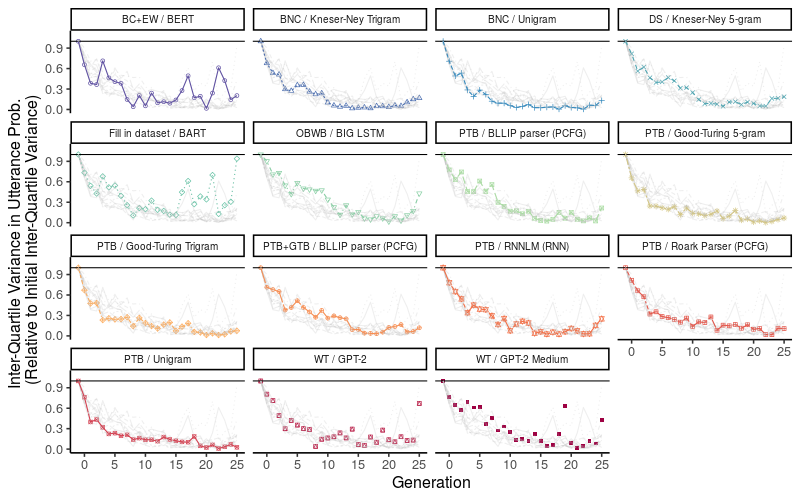

In [148]:
def varianceReductionPlot(df, measureVars, graphTitle, maxGeneration=0):
    # make a plot that shows what happens to variance at each instance 

    model_dfs = []
    for measureVar in measureVars:
        factorVar = measureVar.replace('normalized_','initial_')+'_quartile'
            #take the variance with respect to some factor
            # get the mean for each factorVar          
        by_factor = df.groupby([factorVar, 'upstream_pointer'])[measureVar].agg([np.mean, np.std, scipy.stats.sem]).reset_index()
        
        # get the standard deviation across means ~ factorVar
        by_position = by_factor.groupby(['upstream_pointer'])['mean'].agg([np.std]).reset_index()
            # take the standard deviation among those factors        
            
        by_position['var'] = by_position['std'] ** 2.  #square the standard deviation to get the variance

        initial_variance  = by_position.iloc[0]['var'] 
        #print(initial_variance)
        #print(by_position)
        # this is guaranteed to be the same for all chains because they start with the same set of sentences
        by_position['normalized_var'] = by_position['var'] / initial_variance
        by_position['model'] = measureVar.replace('normalized_','')
        model_dfs.append(by_position)
 
    single_df = pd.concat(model_dfs)
    %R -i single_df,maxGeneration                            
    %R if (maxGeneration != 0){single_df = subset(single_df, upstream_pointer <= maxGeneration)}
    %R single_df$model = revalue(single_df$model, c( \
        "biglm_probability" = "OBWB / BIG LSTM", \
        "BNC_KNN_trigramProb" = "BNC / Kneser-Ney Trigram", \
        "BNC_KNN_unigramProb" = "BNC / Unigram", \
        "WSJ_Roark_Negative.Log.Probability" = "PTB / Roark Parser (PCFG)", \
        "kenlm_probability" = "DS / Kneser-Ney 5-gram", \
        "bllip_probability" = "PTB+GTB / BLLIP parser (PCFG)", \
        "bllip_wsj_probability" = "PTB / BLLIP parser (PCFG)", \
        "mikolov_wsj_probability" = "PTB / RNNLM (RNN)", \
        "WSJ_gt_unigramProb" = "PTB / Unigram", \
        "WSJ_gt_trigramProb" = "PTB / Good-Turing Trigram", \
        "WSJ_gt_5gramProb" = "PTB / Good-Turing 5-gram", \
        "gpt2_normal_probability" = "WT / GPT-2", \
        "gpt2_medium_probability" = "WT / GPT-2 Medium", \
        "bert_probability" = "BC+EW / BERT", \
        "bart_probability" = "Fill in dataset / BART"))
    %R colorCount = length(levels(as.factor(single_df$model)))
    %R print(colorCount)
    %R ref_dfs = do.call('rbind', lapply(unique(single_df$model), function(model){ get_ref_df(model, single_df)}))       
    %R p1 = ggplot(single_df)+ theme_classic(base_size = 16) + xlab('Generation') \
    + geom_point(aes(x=upstream_pointer,y=normalized_var, colour=model, shape=model))  \
    + scale_shape_manual(values=1:colorCount) \
    + ylab('Inter-Quartile Variance in Utterance Prob. \n (Relative to Initial Inter-Quartile Variance)') \
    + coord_cartesian(ylim=c(0,1.1)) \
    + geom_hline(yintercept=1)  \
    + geom_line(data=ref_dfs, aes(x=upstream_pointer,y=normalized_var, linetype=line_model),colour='gray', alpha=.25) \
    + geom_line(aes(x=upstream_pointer,y=normalized_var, colour=model, linetype=model)) \
    + guides(shape=guide_legend(title="Model"),colour=guide_legend(title="Model"),linetype=guide_legend(title="Model")) \
    + scale_color_manual(values = rev(colorRampPalette(brewer.pal(11,"Spectral")[c(c(1:4),c(8:11))])(colorCount))) \
    + facet_wrap(~model) \
    + theme(legend.position='none', strip.text.x = element_text(size = 10))

    %R ggsave('figures/modelConvergenceAssessment.pdf', plot=p1, height=6, width=12)
    %R  -w 800 -h 500 print(p1)
    return(single_df)

single_df = varianceReductionPlot(all_runs, normalizedVars[::-1], '', maxGeneration=25)

this is a necessary (but insufficient) condition of convergence for the n-gram models, with evidence that the cahins are converging fastest for the unigram probability model

# Normalized Probabilities

In [ ]:
# Functions with R code. Cannot be added to the telephone_analysis helper
def normalizedProbabilityPlot(df, measureVars, graphTitle, outputPath, normalize=True,
    firstGen=0, lastGen=25, normalizeWrt=-1, minChainLength=0):
    # standard error of the mean, stratified by initial conditions
    model_dfs = [] 
    df = df.loc[df.chain_length > minChainLength]
    for measureVar in measureVars:
    
        initial_mean_score = np.mean(df.loc[df.upstream_pointer == normalizeWrt][measureVar])
        if normalize:
            df['surprisal'] = -1 * np.log2(10. ** df[[measureVar]])
            by_factor = df.groupby(['upstream_pointer'])['surprisal'].agg([np.mean, scipy.stats.sem]).reset_index()
            initial = by_factor.loc[by_factor.upstream_pointer == -1].iloc[0]['mean']
            by_factor['mean']  = by_factor['mean']  - initial
            ylab_text= 'Change in Per-Word Surprisal (bits)'
            #df['normalized_measure_var'] = df[measureVar] / initial_mean_score 
            #df['normalized_measure_var'] = np.log(10**df[measureVar] / 10**initial_mean_score) 
            
            #by_factor = df.groupby(['upstream_pointer'])['normalized_measure_var'].agg([np.mean, scipy.stats.sem]).reset_index()
            #ylab_text= 'Log Likelihood Ratio Under Language Model \n (Relative to Initial Probability)'
        else:
            df['surprisal'] = -1 * np.log2(10. ** df[[measureVar]])
            by_factor = df.groupby(['upstream_pointer'])['surprisal'].agg([np.mean, scipy.stats.sem]).reset_index()
            ylab_text= 'Per-Word Surprisal (bits)'
            
        by_factor['min'] = by_factor['mean'] - by_factor['sem']
        by_factor['max'] = by_factor['mean'] + by_factor['sem']        
        by_factor['model'] = measureVar.replace('normalized_','')
        
        model_dfs.append(by_factor)        
        
    single_model = pd.concat(model_dfs)
    
    %R -i single_model,firstGen,lastGen,ylab_text,normalize,outputPath,normalizeWrt,minChainLength
    %R single_model = subset(single_model, upstream_pointer <= lastGen \
    & upstream_pointer >= firstGen)
    %R print(levels(single_model$model))
    # dataset / model (type)
    %R single_model$model = revalue(single_model$model, c( \
        "biglm_probability" = "OBWB / BIG LSTM", \
        "BNC_KNN_trigramProb" = "BNC / Kneser-Ney Trigram", \
        "BNC_KNN_unigramProb" = "BNC / Unigram", \
        "WSJ_Roark_Negative.Log.Probability" = "PTB / Roark Parser (PCFG)", \
        "kenlm_probability" = "DS / Kneser-Ney 5-gram", \
        "bllip_probability" = "PTB + GTB / BLLIP parser (PCFG)", \
        "bllip_wsj_probability" = "PTB / BLLIP parser (PCFG)", \
        "mikolov_wsj_probability" = "PTB / RNNLM (RNN)", \
        "WSJ_gt_unigramProb" = "PTB / Unigram", \
        "WSJ_gt_trigramProb" = "PTB / Good-Turing Trigram", \
        "WSJ_gt_5gramProb" = "PTB / Good-Turing 5-gram", \
        "gpt2_normal_probability" = "WT / GPT-2", \
        "gpt2_medium_probability" = "WT / GPT-2 Medium", \
        "bert_probability" = "BC+EW / BERT", \
        "bart_probability" = "Fill Dataset / BART" \
    ))
    %R single_model$model <- factor( single_model$model , ordered = FALSE )
    
    # make a large enough color palette
    %R getPalette <- colorRampPalette(brewer.pal(9, "Set1"))
    %R colorCount = length(levels(single_model$model))
    %R ref_dfs = do.call('rbind', lapply(unique(single_model$model), function(model){ get_ref_df(model, single_model)}))       
    %R if (normalizeWrt > 10){pd <- position_dodge(width = 0.4)} else {pd <- position_dodge(width = 0)}
    %R p1 = ggplot(single_model)
    %R p1 = p1 + geom_line(data=ref_dfs, aes(x=upstream_pointer,y=mean, linetype=line_model), colour='gray', alpha=.25)
    %R p1 = p1 + geom_line(aes_string(y='mean', x='upstream_pointer', colour='model', linetype='model'), position=pd)
    %R p1 = p1 + theme_classic(base_size = 16)    
    %R p1 = p1 + xlab('Generation')
    %R p1 = p1 + geom_point(aes_string(y='mean', x='upstream_pointer',colour='model',shape='model'), position = pd)
    %R p1 = p1 + scale_shape_manual(values=1:nlevels(single_model$model))
    %R p1 = p1 + geom_linerange(aes(x=upstream_pointer, ymin=min, ymax=max, colour=model), alpha=.5, position = pd)
    %R p1 = p1 +ylab(ylab_text)
    %R p1 = p1 +guides(shape=guide_legend(title="Model"),colour=guide_legend(title="Model"),linetype=guide_legend(title="Model")) 
    %R p1 = p1 +scale_color_manual(values = rev(colorRampPalette(brewer.pal(11,"Spectral")[c(c(1:4),c(8:11))])(colorCount)))
    %R p1 = p1 +facet_wrap(~model)
    %R p1 = p1 +theme(legend.position='none', strip.text.x = element_text(size = 10)) 
    
    %R if (normalize){p1 = p1 + geom_hline(yintercept=0.0, colour='black')}
    
    %R ggsave(outputPath, plot=p1, height=6, width=12)
    
    %R -w 1000 -h 500  print(p1)
    return(single_model)

single_model = normalizedProbabilityPlot(all_runs, normalizedVars, '',
outputPath='figures/modelProbabilityComparison_normalized_len25filtered.pdf', firstGen=0, 
lastGen=25, minChainLength=25)    

/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NULL


/home/nwong/chompsky/serial_chain/telephone-analysis-public/telephone-env-3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "model". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


In [ ]:
for item in all_runs.columns:
    print(item)

In [ ]:
single_model = normalizedProbabilityPlot(all_runs, normalizedVars, '', outputPath='figures/modelProbabilityComparison_normalized.pdf', firstGen=0, lastGen=25, normalizeWrt=-1)    

In [ ]:
wsj_only_vars = ['normalized_'+ x for x in [
    u'WSJ_Roark_Negative.Log.Probability', 
    'bllip_wsj_probability',
    'mikolov_wsj_probability',
    'WSJ_gt_unigramProb',
    'WSJ_gt_trigramProb', 
    'WSJ_gt_5gramProb']]
single_model = normalizedProbabilityPlot(all_runs, wsj_only_vars, '','figures/modelProbabilityComparison_normalized_wsjOnly.pdf', firstGen=0, lastGen=25, normalizeWrt=-1)

In [ ]:
single_model = normalizedProbabilityPlot(all_runs, normalizedVars, '', 'figures/modelProbabilityComparison_raw.pdf', normalize=False, firstGen=0, lastGen=25)

high initial, small decrease:
WSJ Unigram

high initial, large decrease:
BNC Unigram
WSJ BLLIP
RNNLM
Roark parser

low initial, small decrease:
WSJ Trigram
WSJ 5-gram

low initial, large decrease:
WSJ+GTB BLLIP
BNC Trigram
DS 5-gram
Big LM

# Statistical Tests

In [ ]:
#surprisal ~ model + architecture  + dataset * poly(generation,2) +(1+generation|thread_id+model)

In [ ]:
%R -i all_runs

In [ ]:
%%R
measure_vars = c('normalized_biglm_probability', 'normalized_WSJ_Roark_Negative.Log.Probability', 
          'normalized_BNC_KNN_unigramProb', 'normalized_BNC_KNN_trigramProb','normalized_kenlm_probability',
        'normalized_bllip_probability','normalized_bllip_wsj_probability', 'normalized_mikolov_wsj_probability','normalized_WSJ_gt_unigramProb'
        ,'normalized_WSJ_gt_trigramProb', 'normalized_WSJ_gt_5gramProb',
                 'normalized_gpt2_normal_probability', 'normalized_gpt2_medium_probability', 'normalized_bert_probability',
                'normalized_bart_probability')

index_vars = c('upstream_pointer', 'thread_id')

all_runs_short = all_runs[,c(measure_vars, index_vars)]
all_runs_melted = melt(all_runs_short, id.vars =index_vars, measure.vars = measure_vars)
names(all_runs_melted)
all_runs_melted$value = -1 * all_runs_melted$value # base 10 surprisal
names(all_runs_melted) = c('generation','thread_id','model','surprisal')

# get the estimate of surprisal with the initial surprisal subtracted
initial_surprisal_df = subset(all_runs_melted, generation == -1)
names(initial_surprisal_df) = c('generation','thread_id','model','initial_surprisal')
initial_surprisal_df$generation = NULL

all_runs_melted = merge(all_runs_melted, initial_surprisal_df)
all_runs_melted$change_in_surprisal = -1 * (all_runs_melted$surprisal - all_runs_melted$initial_surprisal)
# higher change = more likely

all_runs_melted$architecture = revalue(all_runs_melted$model, c( 
    "normalized_WSJ_Roark_Negative.Log.Probability" = "Roark Parser (PCFG)", 
    "normalized_bllip_wsj_probability" = "BLLIP parser (PCFG)", 
    "normalized_mikolov_wsj_probability" = "RNNLM (RNN)", 
    "normalized_WSJ_gt_unigramProb" = "Unigram", 
    "normalized_WSJ_gt_trigramProb" = "Trigram",
    "normalized_WSJ_gt_5gramProb" = "5-gram",
    "normalized_biglm_probability" = "Big LSTM",
    "normalized_BNC_KNN_trigramProb" = "Trigram",
    "normalized_BNC_KNN_unigramProb" = "Unigram",
    "normalized_kenlm_probability" = "5-gram)",
    "normalized_gpt2_normal_probability" = "GPT-2",
    "normalized_gpt2_medium_probability" = "GPT-2 medium",
    "normalized_bert_probability" = "BERT",
    "normalized_bart_probability" = "BART"))

all_runs_melted$dataset = sapply(all_runs_melted$model, function(x){ 
    if (length(grep('wsj', x, ignore.case=T)) > 0){ 
        return('PTB') 
    } else {
        return('Largest') 
}})

all_runs_melted$context = sapply(all_runs_melted$architecture, function(x){
    if (as.character(x) == 'Unigram'){ 
        return('not used') 
    } else{ 
        return('used') 
}})


all_runs_melted$abstractStructure = as.factor(sapply(all_runs_melted$architecture, function(x){
    if (as.character(x) == 'Unigram'){
        return(NA)
    } else if (as.character(x) %in% c('5-gram','Trigram')){ 
        return('not used') 
    } else{ 
        return('used') 
}}))
all_runs_melted$abstractStructure = relevel(all_runs_melted$abstractStructure, ref = "not used")

all_runs_melted$model_thread = paste(all_runs_melted$model, '_', all_runs_melted$thread_id)

all_runs_melted$context = as.factor(sapply(all_runs_melted$architecture, function(x){
    if (as.character(x) == 'Unigram'){ 
        return('not used') 
    } else{
        return('used') 
    }
#     } else if (as.character(x) %in% c('5-gram', 'Trigram')){ 
#         return('lexical context')
#     } else {
#         return('abstact context')
#     }
}))
all_runs_melted$context = relevel(all_runs_melted$context, ref = "not used")

In [ ]:
%%R 
nrow(subset(all_runs_melted, generation >= 0 & generation <= 25)) /11

# Are Models that Use Structured Representations of Context More Similar to Human Expecations?

In [ ]:
%%R
lm2_null = lmer(surprisal ~ generation * ( dataset ) + (1 + generation | thread_id), 
    data= subset(all_runs_melted, architecture != 'Unigram' & generation <= 25 & generation >= 0 ))

print(summary(lm2_null))
print(AIC(lm2_null))

In [ ]:
%%R
lm2 = lmer(surprisal ~ generation * (abstractStructure + dataset) + (1 + generation | thread_id), 
    data= subset(all_runs_melted, architecture != 'Unigram' & generation <= 25 & generation >= 0 ))

print(summary(lm2))
print(AIC(lm2))

In [ ]:
%%R
anova(lm2_null, lm2)

In [ ]:
%%R
source('telephone_analysis.R')
modelName = 'structureTests'
contextCaption = 'A mixed-effects linear regression examining average per-word surprisal estimates (negative log probability under a model) across 9 language models as a function of 1) whether the model uses an abstract representation of the preceding context to inform expectations and 2) the dataset used to fit the model. Significance of fixed-effects is computed following \\citet{satterthwaite1946}.' 
contextLabel = 'tab:structure_lm'

replacements = list()
replacements[['abstractStructure']] = 'abstract structure: '
replacements[['dataset']] = 'dataset: '
replacements[['generation:']] = 'generation x '
replacements[['thread_id']] = 'Recording Chain'

modelToTable('mixed_linear', modelName, lm2, replacements=replacements,
    file=paste0('LMs/',modelName,'_lm.tex'), printVars = T, caption = contextCaption,
             label = contextLabel, where= 't')

In [ ]:
%%R -w 800 -h 600
#surprisal ~ generation * model

ggplot(subset(all_runs_melted, generation >= 0 & generation <= 25 & architecture != 'Unigram')
) + stat_smooth(aes(x=generation, y=surprisal, colour=model, linetype=abstractStructure)
) + theme_classic() + ylab('Per Word Log10 Surprisal')

# Correlation between language models

In [ ]:
all_runs.columns
# are all of the language models in all_runs?

### Models Trained on All Datasets

In [ ]:
modelNames = [
"OBWB / Big LSTM",
"PTB / Roark Parser (PCFG)",
"BNC / Unigram",
"BNC / Kneser-Ney Trigram",
"DS / Kneser-Ney 5-gram",
"PTB+GTB / BLLIP parser (PCFG)",
"PTB / BLLIP parser (PCFG)",
"PTB / RNNLM (RNN)",
"PTB / Unigram",
"PTB / Good-Turing Trigram",
"PTB / Good-Turing 5-gram",
"WT / GPT-2",
"WT / GPT-2 Medium",
"BC+EW / BERT",
"Fill Dataset / BART"
]

measureVars = ['biglm_probability', u'WSJ_Roark_Negative.Log.Probability', 
           u'BNC_KNN_unigramProb', u'BNC_KNN_trigramProb','kenlm_probability','bllip_probability',
         'bllip_wsj_probability', 'mikolov_wsj_probability','WSJ_gt_unigramProb'
         ,'WSJ_gt_trigramProb', 'WSJ_gt_5gramProb',
               'gpt2_normal_probability', 'gpt2_medium_probability', 'bert_probability', 'bart_probability'
]

# get pairwise combinations of probabilities for the language models
corTable = np.zeros([len(measureVars), len(measureVars)])
for i in range(len(measureVars)):
    for j in range(len(measureVars)):
        corTable[i,j] = scipy.stats.spearmanr(all_runs[measureVars[i]], all_runs[measureVars[j]])[0]


corDF = pd.DataFrame(corTable)
corDF.columns = modelNames
corDF.index = corDF.columns
%R -i corDF

In [ ]:
%%R -w 1000 -h 1000
p1 = ggcorrplot(corDF, outline.col = "white", hc.order=T, lab = TRUE, lab_size =6)
p1 = p1 + theme(legend.position="none")
print(p1)
ggsave('figures/similarityInLanguageModels_allModels.pdf', plot=p1, height=6, width=6)
ggsave('figures/similarityInLanguageModels_allModels.png', plot=p1, height=6, width=6)

In [ ]:
%%R
d <- dist(1-corDF) # euclidean distances between the rows
hc <- hclust(d, method = "ward.D2")  
hcd <- as.phylo(hc)
# Default plot
plot(hcd, type = "cladogram", horiz = TRUE,  label.offset = 0.05)

pdf('figures/lm_dendrogram_all_models.pdf')
plot(hcd, type = "cladogram", horiz = TRUE,  label.offset = 0.05)
dev.off()

png('figures/lm_dendrogram_all_models.png')
plot(hcd, type = "cladogram", horiz = TRUE,  label.offset = 0.05)
dev.off()

- PTB unigram and GT are close together
- KN and Big lST close roether
- BLLIP parser close together
- BNC unigram and RNNLM unlike other things

### Models trained on PTB Only

In [ ]:
# modelNames = [
# "Roark Parser",
# "BLLIP Parser",
# "RNNLM ",
# "Unigram",
# "Good-Turing Trigram",
# "Good-Turing 5-gram" ]

modelNames = [
"PTB / Roark Parser (PCFG)",
"PTB / BLLIP parser (PCFG)",
"PTB / RNNLM (RNN)",
"PTB / Unigram",
"PTB / Good-Turing Trigram",    
"PTB / Good-Turing 5-gram"    
]

In [ ]:
#measureVars = normalizedVars -- all models
measureVars = [u'WSJ_Roark_Negative.Log.Probability', 
          'bllip_wsj_probability','mikolov_wsj_probability',
        'WSJ_gt_unigramProb','WSJ_gt_trigramProb', 'WSJ_gt_5gramProb']


# get pairwise combinations of probabilities for the language models
corTable = np.zeros([len(measureVars), len(measureVars)])
for i in range(len(measureVars)):
    for j in range(len(measureVars)):
        corTable[i,j] = scipy.stats.spearmanr(all_runs[measureVars[i]], all_runs[measureVars[j]])[0]


corDF = pd.DataFrame(corTable)
corDF.columns = modelNames
corDF.index = corDF.columns
print(corDF)
%R -i corDF



In [ ]:
%%R
p1 = ggcorrplot(corDF, outline.col = "white", hc.order=T, lab = TRUE, lab_size =6)
p1 = p1 + theme(legend.position="none")
print(p1)
ggsave('figures/similarityInLanguageModels.pdf', plot=p1, height=6, width=6)

In [ ]:
%%R
d <- dist(1-corDF) # euclidean distances between the rows
hc <- hclust(d, method = "ward.D2")  
hcd <- as.phylo(hc)
# Default plot
p1 = plot(hcd, type = "cladogram", horiz = TRUE,  label.offset = 0.05)

pdf('figures/lm_dendrogram.pdf')
plot(hcd, type = "cladogram", horiz = TRUE,  label.offset = 0.05)
dev.off()

# Confirm total number of users

In [ ]:
len(np.unique(all_runs.user)) -1